In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Lipinski
from rdkit.Chem import Descriptors
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import rdMolDescriptors

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows',300)
pd.set_option('display.max_column',50)

In [2]:
df = pd.read_csv("data/Green PeLED Passivation_csv.csv")
print("shape:",df.shape)
df.head()

shape: (129, 14)


,Number,PeLEDs component,PA,IsomericSMILES,A_site,Conc(mg/ml),Control device EQE,Passivated device EQE,EQE enhanced ratio,article title,Doi,Emitting Layer structure,year,Unnamed: 13
0,1,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,organic,2.000,2.79%,4.40%,1.5771,Improving Green Perovskite Nanoplate Light-Emi...,https://doi.org/10.1021/acsanm.3c06224,quasi-2D,2024,NaN
1,1,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,organic,4.000,2.79%,7.31%,2.6201,Improving Green Perovskite Nanoplate Light-Emi...,https://doi.org/10.1021/acsanm.3c06224,quasi-2D,2024,NaN
2,1,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,organic,6.000,2.79%,5.85%,2.0968,Improving Green Perovskite Nanoplate Light-Emi...,https://doi.org/10.1021/acsanm.3c06224,quasi-2D,2024,NaN
3,2,CsPbBr3,Lithium bromide,[Li+].[Br-],inorganic,1.738,2.83%,7.92%,2.7986,High-Performance Perovskite Light-Emitting Dio...,https://doi.org/10.1002/anie.201914000,3D,2019,NaN
4,2,CsPbBr3,Lithium bromide,[Li+].[Br-],inorganic,3.476,2.83%,16.20%,5.7244,High-Performance Perovskite Light-Emitting Dio...,https://doi.org/10.1002/anie.201914000,3D,2019,NaN


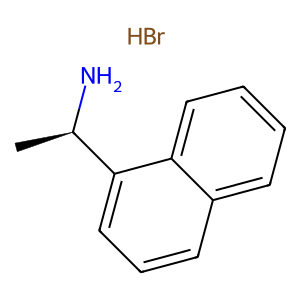

In [3]:
#molecule visualization
mol = Chem.MolFromSmiles(' C[C@H](C1=CC=CC2=CC=CC=C21)N.Br')
# mol = Chem.AddHs(mol)
img = Draw.MolToImage(mol)
img

In [4]:
#halide atom accumulator
def Halide_accumulator(mol):
    Num_Fluorine_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 9)#F
    Num_Chlorine_Atoms = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 17)#Cl
    Num_Bromine_Atoms = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 35)#Br
    Num_Iodine_atoms = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 53)#I
    Num_Halide_Atoms =  Num_Fluorine_atoms + Num_Chlorine_Atoms +Num_Bromine_Atoms +  Num_Iodine_atoms
    return Num_Halide_Atoms

In [5]:
data_set = df.iloc[:,1:9]
print("data_set shape:",data_set.shape)
data_set.head()

data_set shape: (129, 8)


,PeLEDs component,PA,IsomericSMILES,A_site,Conc(mg/ml),Control device EQE,Passivated device EQE,EQE enhanced ratio
0,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,organic,2.000,2.79%,4.40%,1.5771
1,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,organic,4.000,2.79%,7.31%,2.6201
2,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,organic,6.000,2.79%,5.85%,2.0968
3,CsPbBr3,Lithium bromide,[Li+].[Br-],inorganic,1.738,2.83%,7.92%,2.7986
4,CsPbBr3,Lithium bromide,[Li+].[Br-],inorganic,3.476,2.83%,16.20%,5.7244


In [6]:
smi = data_set['IsomericSMILES'].to_list()#获取钝化分子SMILES
feature_columns = [
    'Heavy_atoms',
    'H_Acceptors',
    'H_Donors',
    'Rot_bonds',
    'Val_electrons',
    'Mol_Wt',
    'Topo',
    'TPSA',
    'AvgIpc',
 

    'Carbon',
    'Hydrogen',
    'Oxide',
    'Notrigen',
    
    'Halide',
    
 
]
# 添加新列并初始化为默认值为0
for col in feature_columns:
    data_set[col] = ' ' #初值设置为空

print(f"shape:{data_set.shape}")
data_set = data_set.iloc[:,:]

shape:(129, 22)


In [7]:
for i in range(len(smi)):
    mol_hided_H = Chem.MolFromSmiles(smi[i])
    mol = Chem.AddHs(mol_hided_H)#显化氢原子
    
    data_set.loc[i,'Heavy_atoms'] = Lipinski.HeavyAtomCount(mol)#重原子数
  
    data_set.loc[i,'H_Acceptors'] = Lipinski.NumHAcceptors(mol)#氢键受体
    
    data_set.loc[i,'H_Donors'] = Lipinski.NumHDonors(mol)#氢键供体
    data_set.loc[i,'Rot_bonds'] = Lipinski.NumRotatableBonds(mol)#转动键数量
    data_set.loc[i,'Val_electrons'] = Descriptors.NumValenceElectrons(mol)#价电子数
    data_set.loc[i,'Mol_Wt'] = Descriptors.MolWt(mol)#平均分子重量
  
    data_set.loc[i,'Topo'] = GraphDescriptors.BertzCT(mol)#拓扑指数（描述复杂度；两项总和，1成键的复杂性，2杂原子分布复杂性）//test remove
    data_set.loc[i,'TPSA'] = Descriptors.TPSA(mol)#拓扑分子极化表面积
    data_set.loc[i,'AvgIpc'] = GraphDescriptors.AvgIpc(mol)#information for polynomial coefficients of a molecular graph
  
    
    #特定原子数
    data_set.loc[i,'Carbon'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)#C
    data_set.loc[i,'Hydrogen'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 1)#H
    data_set.loc[i,'Oxide'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8)#O
    data_set.loc[i,'Notrigen'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 7)#N
     
    #卤素原子
   
    data_set.loc[i,'Halide'] = Halide_accumulator(mol)
    
   
dataset_add_features = data_set.iloc[:len(smi),:]

dataset_add_features = dataset_add_features[dataset_add_features['EQE enhanced ratio'] <= 5.0]#对目标属性的增长率进行控制

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
dataset_add_features['A_site'] = encoder.fit_transform(dataset_add_features[['A_site']])
print(f"shape:{dataset_add_features.shape}") 


dataset_add_features.to_csv("data/dataset_with_features.csv",index=False)


shape:(123, 22)


In [8]:
dataset_add_features

,PeLEDs component,PA,IsomericSMILES,A_site,Conc(mg/ml),Control device EQE,Passivated device EQE,EQE enhanced ratio,Heavy_atoms,H_Acceptors,H_Donors,Rot_bonds,Val_electrons,Mol_Wt,Topo,TPSA,AvgIpc,Carbon,Hydrogen,Oxide,Notrigen,Halide
0,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,0.0,2.000,2.79%,4.40%,1.5771,20,4,0,3,116,305.315,1027.262645,54.48,2.663596,12,24,4,3,0
1,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,0.0,4.000,2.79%,7.31%,2.6201,20,4,0,3,116,305.315,1027.262645,54.48,2.663596,12,24,4,3,0
2,PPA2FAn–1PbnBr3n+1,trimorpholinophosphine oxide,C1COCCN1P(=O)(N2CCOCC2)N3CCOCC3,0.0,6.000,2.79%,5.85%,2.0968,20,4,0,3,116,305.315,1027.262645,54.48,2.663596,12,24,4,3,0
3,CsPbBr3,Lithium bromide,[Li+].[Br-],1.0,1.738,2.83%,7.92%,2.7986,2,0,0,0,8,86.845,2.0,0.0,0.0,0,0,0,0,1
5,PEA2PbBr4(CsPbBr3)4,ethoxylated trimethylolpropane triacrylate,CCC(COCCOC(=O)C=C)(COCCOC(=O)C=C)COCCOC(=O)C=C,1.0,5.000,16.79%,22.49%,1.3395,30,9,0,20,170,428.478,1614.338425,106.59,2.991211,21,32,9,0,0
6,PEA2(FAPbBr3)n-1PbBr4 (n=3),trioctylphosphine oxide,CCCCCCCCP(=O)(CCCCCCCC)CCCCCCCC,0.0,2.000,10.00%,14.36%,1.4360,26,1,0,24,158,386.645,1960.351438,17.07,3.168273,24,51,1,0,0
7,PEA:CsPbBr3,methylene-bis-acrylamide,C=CC(=O)NCNC(=O)C=C,1.0,4.625,11.30%,16.80%,1.4867,11,2,2,4,60,154.169,463.5356,58.2,2.411218,7,10,2,2,0
8,PEA:CsPbBr3,ammonium thiocyanate,C(#N)[S-].[NH4+],1.0,4.000,3.20%,10.50%,3.2813,4,2,1,0,24,76.124,75.01955,60.29,1.272906,1,4,0,2,0
9,PEA:CsPbBr3,ammonium thiocyanate,C(#N)[S-].[NH4+],1.0,6.000,3.20%,14.70%,4.5938,4,2,1,0,24,76.124,75.01955,60.29,1.272906,1,4,0,2,0
10,PEA:CsPbBr3,ammonium thiocyanate,C(#N)[S-].[NH4+],1.0,8.000,3.20%,11.30%,3.5313,4,2,1,0,24,76.124,75.01955,60.29,1.272906,1,4,0,2,0
